## Movement Decider

In [1]:
from src.sensor import Camera

mba_video_camera = Camera(
    h_fov=59.0,
    h_res=1080,
    v_res=720,
)

mba_photo_camera = Camera(
    h_fov=67.0,
    h_res=1290,
    v_res=720,
)

zed_two_camera = Camera(
    h_fov=110.0,
    v_fov=70.0,
)

avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [2]:
import matplotlib.pyplot as plt
from src.vehicle import Vehicle
from src.vehicle import VehicleMover
from src.point import Point
from src.sensor import FakeSensor, Sensor
from src.point import create_map
import pandas as pd
import numpy as np
import time

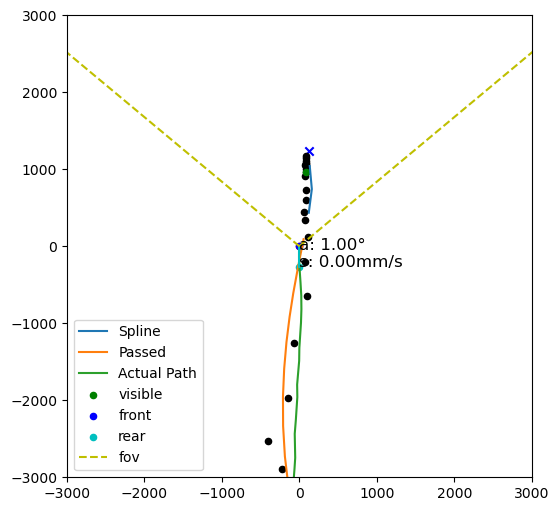

No time to wait


In [3]:
# SENSOR
# sensor_data = pd.read_csv('csv/dist_2fps.csv', header=None)
# sensor_data.columns = ['t', 'x', 'y']
# sensor_data['t'] = sensor_data['t'].astype(float)
# sensor = FakeSensor(sensor_data, to_recenter=True)
sensor = Sensor('io/pe.csv', refresh_rate=1)

# VEHICLE
verbose = True
vehicle = Vehicle(
    max_turn_angle=30, 
    axle_len=265, 
    max_speed=2000, 
    camera=zed_two_camera,
    center=Point(0, 0)
)

# VEHICLE MOVER
vehicle_mover = VehicleMover(
    vehicle, 
    sensor, 
    'io/md.csv', 
    frame_rate=4, 
    follow_distance=1200,
    turn_distance=600,
)

while not vehicle_mover.is_done():
    start = time.time()
    incoming, passed, last_seen, target = vehicle_mover.step()

    if verbose:
        fig, ax = create_map(Point(0, 0), 6000, 6)
        ax.scatter(target.y, target.x, marker='x', color='b')
        ax.plot(incoming['y'], incoming['x'], label='Spline')
        ax.plot(passed['y'], passed['x'], label='Passed')
        Point(0, 0).scatter(ax, color='r', size=20)
        for x in range(len(vehicle_mover.seen)):
            Point.from_df(vehicle_mover.seen.iloc[x]).scatter(ax, color='k', size=20)

        ax.plot(vehicle_mover.actual_path['y'], vehicle_mover.actual_path['x'], label='Actual Path')

        sensor.scatter_host(ax, vehicle)
        vehicle.plot(ax)
        ax.legend()
        plt.show()

    delta = time.time() - start
    wait_time = vehicle_mover.frame_time() - delta
    if wait_time > 0: time.sleep(wait_time)
    else: print(f'No time to wait')


# if the angle is more than agle max, back up and turn